<p align = "center" draggable=”false” ><img src="https://user-images.githubusercontent.com/37101144/161836199-fdb0219d-0361-4988-bf26-48b0fad160a3.png" 
     width="200px"
     height="auto"/>
</p>

# 🛍️ Launch New Products

Today you are a machine learning engineer at the Department of New Products at Target Cosmetics! 

We will start with a small dataset on interactions between users and current products from the past and try to discover substructure, if there's any, by applying some **unsupervised learning** methods. 

Then we will leverage the small amount of labeled data (current products) in combination with a larger amount of unlabeled data (new products to launch) to make estimations as to which products will sell more. 

## 📚 Learning Objectives

By the end of this session, you will be able to:

- apply dimensionality reduction techniques to reduce features to a lower dimensional space
- perform customer segmentation, determine optional number of clusters, and understand assumptions for used algorithm
- understand what semi-supervised learning is and leverage it to improve performance of supervised learning

## Task 1. Dimensionality Reduction

1. Load in the data. 
    
    Import `pandas` as `pd` and use `pd.read_csv()` to read in `past.csv.gz` in the `dat` folder, saving it as `past`. 
    
    Data in `past.csv.gz` was propcessed; e.g., features indicating time of day, day of week, month, and year of the purchase have been converted to one-hot representations of these categories. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
past = pd.read_csv('../dat/past.csv.gz')
past.columns

Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')

<details>
<summary> Expected output </summary>

```
Index(['product_id', 'user_id', 'NumOfEventsInJourney', 'NumSessions',
       'interactionTime', 'maxPrice', 'minPrice', 'NumCart', 'NumView',
       'NumRemove', 'InsessionCart', 'InsessionView', 'InsessionRemove',
       'Weekend', 'Fr', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', '2019',
       '2020', 'Jan', 'Feb', 'Oct', 'Nov', 'Dec', 'Afternoon', 'Dawn',
       'EarlyMorning', 'Evening', 'Morning', 'Night', 'Purchased?', 'Noon',
       'Category'],
      dtype='object')
```
</details>

2. What percentage of the interactions (rows) resulted in a purchase?

    Do people mostly buy what they look at or do they do a lot of "window shopping" (shopping around without buying)?
    
    From the perspective of classification, is the data balanced?

In [3]:
purchased = past['Purchased?'].mean()
print(f"The percentage of rows that resulted in a purchase is {round(purchased,2)} percent.")

The percentage of rows that resulted in a purchase is 0.34 percent.


3. Drop `product_id` and `user_id` and save the rest columns to a new `pd.DataFrame`:`X`; then pop the column `'Purchased?'` and save it to `y`.

In [4]:
X = past.drop(columns=['product_id', 'user_id']) # drop the id columns
y = X.pop('Purchased?') # pop the target column

In [5]:
assert X.shape == (5000, 34)
assert y.shape == (5000,)

4. Apply [PCA (check documentation if unfamiliar)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the number of features down to **5**, save it to a numpy array named `X_reduced`. 

    Do you need to preprocess the data before performing PCA? Quick review [here: Importance of feature scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html).
    
    If time permits, read [Does mean centering or feature scaling affect a Principal Component Analysis?](https://sebastianraschka.com/faq/docs/pca-scaling.html) or [discussion 1](https://stats.stackexchange.com/questions/53/pca-on-correlation-or-covariance).

In [6]:
scaler = StandardScaler() # Instantiate the scaler
pca = PCA(n_components=5) # Instantiate the PCA object and reduce to 5 components


X_reduced = pca.fit_transform(scaler.fit_transform(X)) # Fit and transform the data

In [7]:
assert X_reduced.shape == (5000, 5)

5. Print out the percentage of variance explained by each of the selected components.

In [8]:
print(pca.explained_variance_ratio_) # Print the explained variance ratio

[0.10282262 0.09445468 0.06514823 0.05103207 0.04275254]


6. Review code in functions `visualize_2pcs` and `visualize_3pcs` below and visualize first few principal components in 2D and 3D plots, respectively:

In [9]:
def visualize_2pcs(pcs, y):
    fig, ax = plt.subplots()
    plot = plt.scatter(pcs[:,0], pcs[:,1], c=y) 
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

In [10]:
def visualize_3pcs(pcs, y):
    fig, ax = plt.subplots()
    ax = fig.add_subplot(projection='3d')
    plot = ax.scatter(pcs[:,0], pcs[:,1], pcs[:,2], c=y)
    ax.legend(
        handles=plot.legend_elements()[0], 
        labels=['No', 'Yes'])

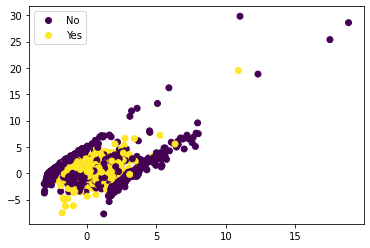

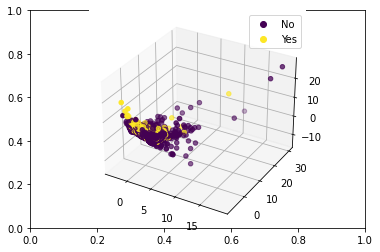

In [11]:
visualize_2pcs(X_reduced, y)
visualize_3pcs(X_reduced, y)

7. One way to assess the quality of the dimensionality reduction, when the groundtruth is available of course, is comparing the prediction performance using given features vs reduced (engineered) features.

    Complete the wrapper function below that 

    - takes features, target, and a boolean parameter indicating whether to include standardization in the pipeline or not
    - split the data into train (80%) and test (20%) datasets, set the random state for spliting at 0
    - build a pipeline that 

        1) preprocessing data using standardization if the `standardize` is `True`; otherwise skip this step  

        2) apply logistic regression ( are the labels balanced? )
        
    - fit the pipeline using training data
    - print the classification report (use `sklearn.metrics.classification_report`) on test data

In [13]:
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

def train(X, y, standardize=True) -> None: # Define the train function
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) # Split the data
    if standardize: # If standardize is True, then standardize the data
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('logistic', LogisticRegression(class_weight='balanced'),)
        ])
    else: # Otherwise, don't standardize the data, and just fit the model
        pipeline = Pipeline([
            ('logistic', LogisticRegression(class_weight='balanced'),)
        ])
    pipeline.fit(X_train, y_train) # Fit the model
    print(classification_report(y_test, pipeline.predict(X_test))) # Print the classification report


#### Now apply the pipeline on the all the features `X` and review the performance

In [14]:
model = train(X, y) # Train the model

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       649
           1       0.55      0.52      0.54       351

    accuracy                           0.68      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.68      0.68      0.68      1000



Similarly, apply the pipeline on the reduced / engineered features `X_reduced`. Should you include standardization in the pipeline?

In [14]:
train(X_reduced, y) # Train the model on the reduced data

              precision    recall  f1-score   support

           0       0.74      0.71      0.72       649
           1       0.50      0.54      0.52       351

    accuracy                           0.65      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.66      0.65      0.65      1000



In [15]:
# Apply standardization on the reduced data
train(X_reduced, y, standardize=True)

              precision    recall  f1-score   support

           0       0.75      0.72      0.73       649
           1       0.51      0.55      0.53       351

    accuracy                           0.66      1000
   macro avg       0.63      0.63      0.63      1000
weighted avg       0.66      0.66      0.66      1000



8. Are the results as expected? Discuss the pros and cons using reduced set of features in this application with your teammate. 

    *Using standardization improved the reduced model, but I was somewhat surprised that the reduced data set didn't peform as well as the model with the full data. This is likley because of the amount of information that was lost during PCA and narrowing the data to five components. The initial data set contained 34 features and some of the key information could have been lost during PCA.*

## Task 2. Customer Segmentation

In this task, we apply k-means clustering on the reduced data, experimenting different vaules of `n_cluster`, summarize all this information in a single plot, the *Elbow* plot. In addition, leverage silhouette visualization to help decide the "optimal" number of clusters in our data and answer: 

1. Are there any patterns among customer purchasing behaviors?
2. If so, what categories do they belong to? How do you characterize the clusters?
3. If not, what followup steps and / or recommendations will you make as an MLE?

1. Look up the [documentation](https://scikit-learn.org/stable/modules/clustering.html) and import the model class for k-means from `sklearn.cluster`

In [16]:
from sklearn.cluster import KMeans

2. Complete `visualize_elbow`; inspect the code and complete

    - fit k-means on the given data `X` and `k`, setting `random_state` to be 10 for reproducibility
    - append the sum of squared distances of samples to their closest cluster center for each $k$ to list `inertias`

In [17]:
def visualize_elbow(X, ks):
    fig, ax = plt.subplots()
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k, random_state=10)
        model.fit(X, k)
        inertias.append(model.inertia_)
    plt.plot(ks, inertias)
    plt.xticks(ks)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow plot')

3. Visualize the elbow plot for the number of clusters ranging between 2 and 9. Discuss with your teammate, what is the 'optimal' number of clusters?

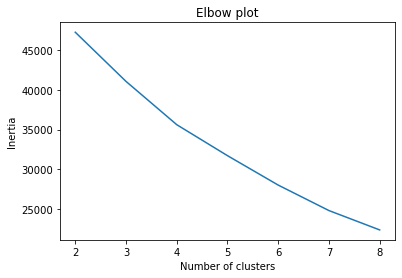

In [18]:
# Visualize the elbow plot for the scaled data
visualize_elbow(X_reduced, range(2, 9))

4. What are the disadvantage to use the Elbow method? 

   *One disadvantage of the elbow method is that it's not always clear where the "elbow" of the plot occurs, which is the point where the rate of decrease begins to level off. This can lead to insconsisent analysis if different analysts are looking at the data. Another disadvantage of the elbow method is that the results of the analysis can vary depending on the starting point of the clusters chosen.*

5. Let's try a different approach: [silhouette score](https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a6).

    A helper function `visualize_silhouette` is provided for you (inspect the code in `utils.py`) and figure out how to use it to visualize k-means for k ranges from 2 to 8 on the reduced data. 

In [19]:
from utils import visualize_silhouette

For n_clusters = 2 The average silhouette_score is : 0.24953483405167334
For n_clusters = 3 The average silhouette_score is : 0.2577698742052374
For n_clusters = 4 The average silhouette_score is : 0.27112263242644197
For n_clusters = 5 The average silhouette_score is : 0.2762790887043975
For n_clusters = 6 The average silhouette_score is : 0.2413206351018414
For n_clusters = 7 The average silhouette_score is : 0.24783120642780426
For n_clusters = 8 The average silhouette_score is : 0.26605716705676025


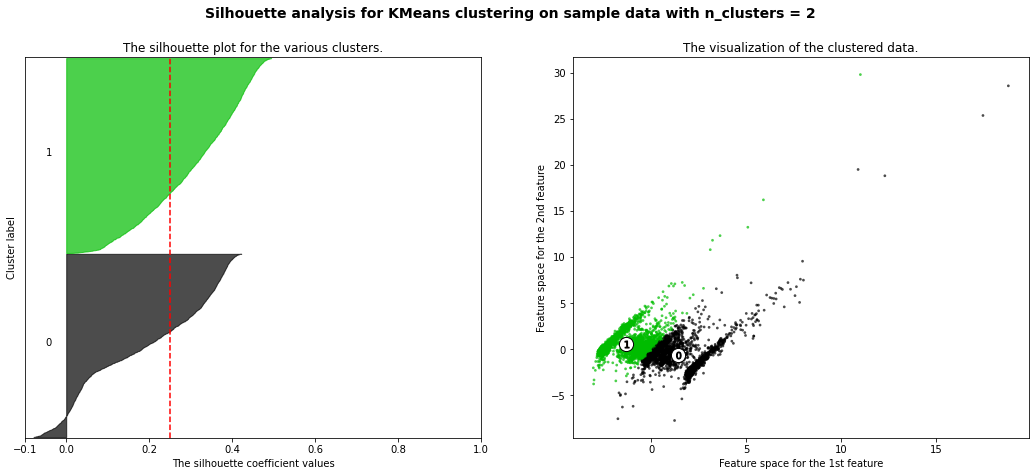

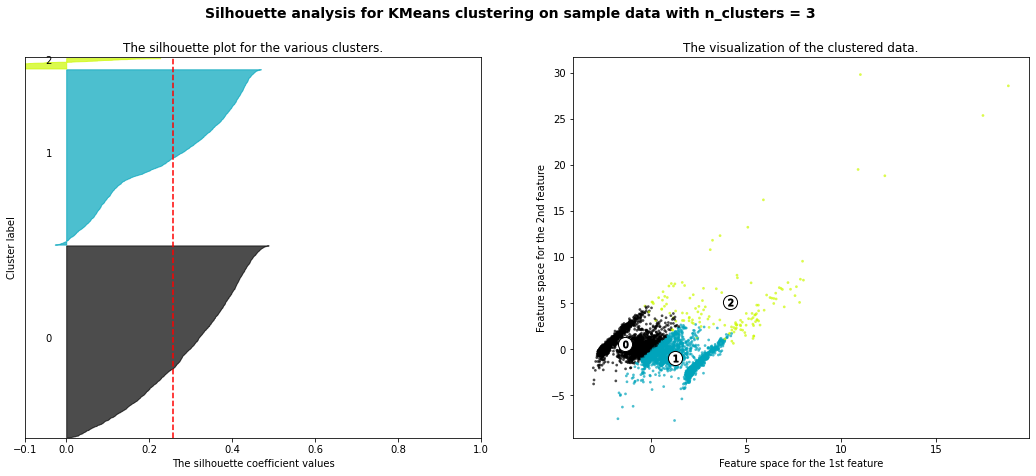

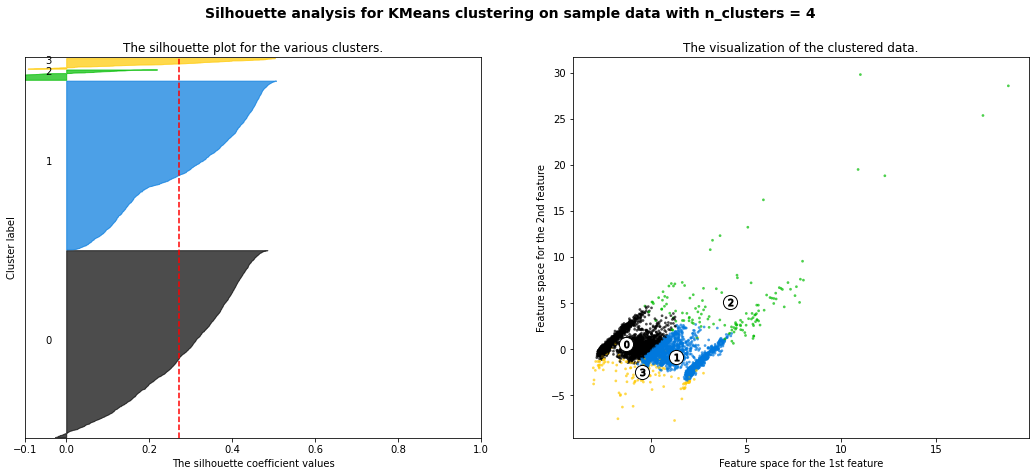

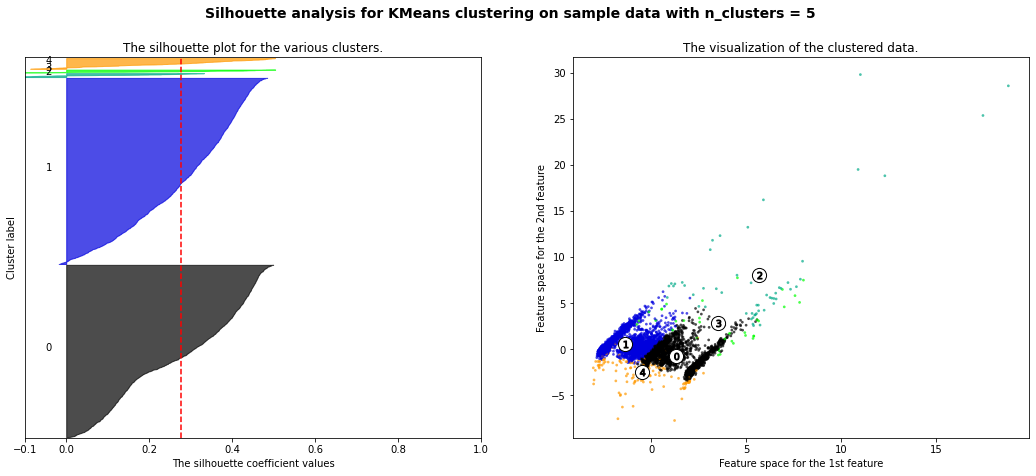

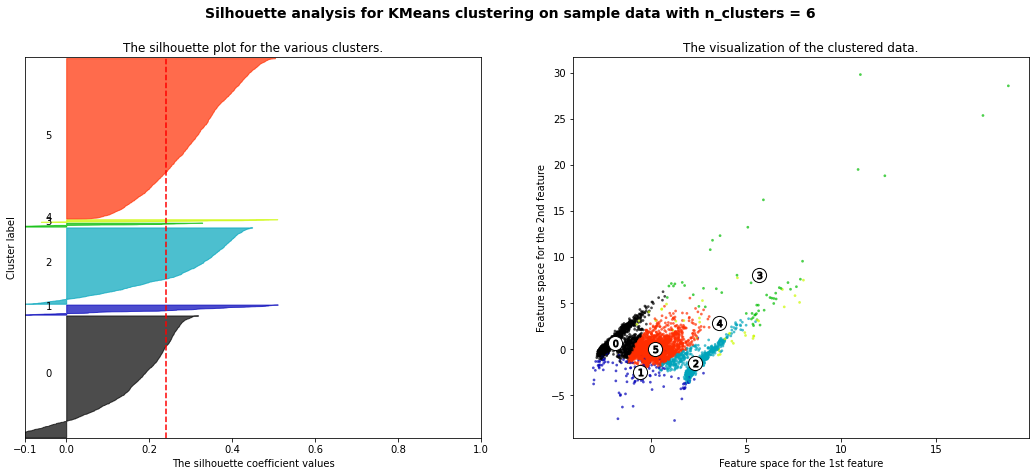

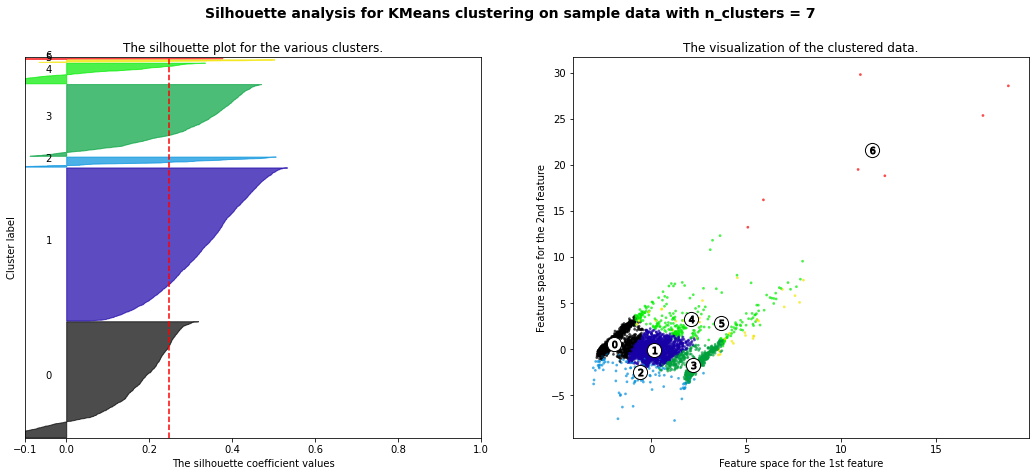

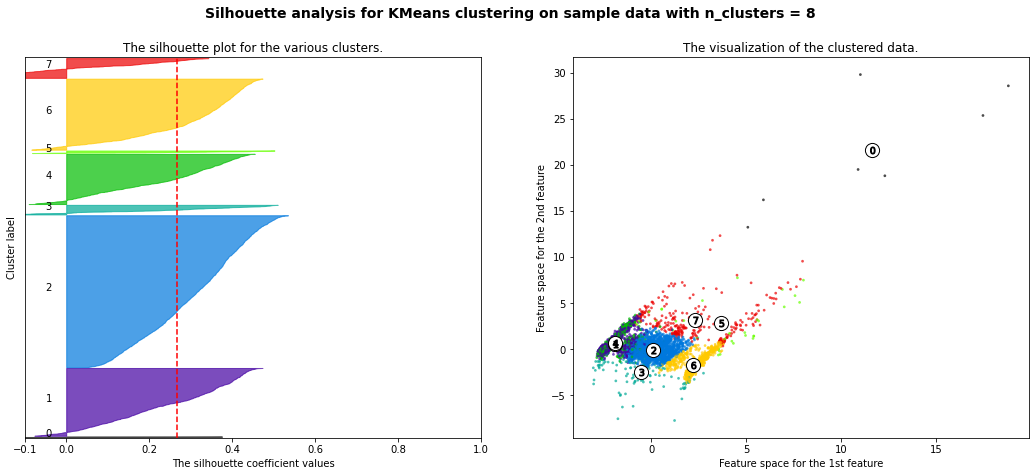

In [20]:
# Visualize the silhouette plot for the scaled data
visualize_silhouette(max_clusters=8, X=X_reduced)

6. Instantiate a k-means model using the number of cluster that you deem optimal, assign it to `km`, and fit on the reduced data. 

In [21]:
km = KMeans(n_clusters=5, random_state=10)
km.fit(X_reduced)

KMeans(n_clusters=5, random_state=10)

7. What is the size of each cluster? 

In [22]:
pd.Series(km.labels_).value_counts()

1    2476
0    2291
4     143
2      53
3      37
dtype: int64

8. Create a new column called `cluster_pca` in `past`, with values as predicted cluster index predicted by `km`. 

In [23]:
past['cluster_pca'] = km.labels_ # Add the cluster labels to the dataframe

In [24]:
past.head()

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category,cluster_pca
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0,0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0,0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0,0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0,0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0,1


9. Open ended: manipulate `past` and see if you can characterize each cluster (e.g., calculate statistics of / visualize features for each cluster), how will you intepret the results? 

    **Note**. This is probably the most important part as far as the business stakeholders are concerned: "*What can I do with your results?*" The math, modeling part is relatively easy, compared to actionable recommendations you make for business. Thus, before jumping on a different algorithm for the given task, do you best to 1) understand the data in depth 2) keep buisiness use cases in mind throughout all steps. 

    *I would look at the Purchased? mean for each of the five components. From here we can see how each component contributes to purchasing and which ones are above the overall average of 34%.*

In [34]:
# Visualize features by cluster
def visualize_features_by_cluster(df, cluster_col, feature_cols):
    fig, axes = plt.subplots(5, 7, figsize=(20, 10))
    for i, col in enumerate(feature_cols):
        ax = axes[i // 7, i % 7]
        df.groupby(cluster_col)[col].mean().plot(kind='bar', ax=ax)
        ax.set_title(col)
    fig.tight_layout()

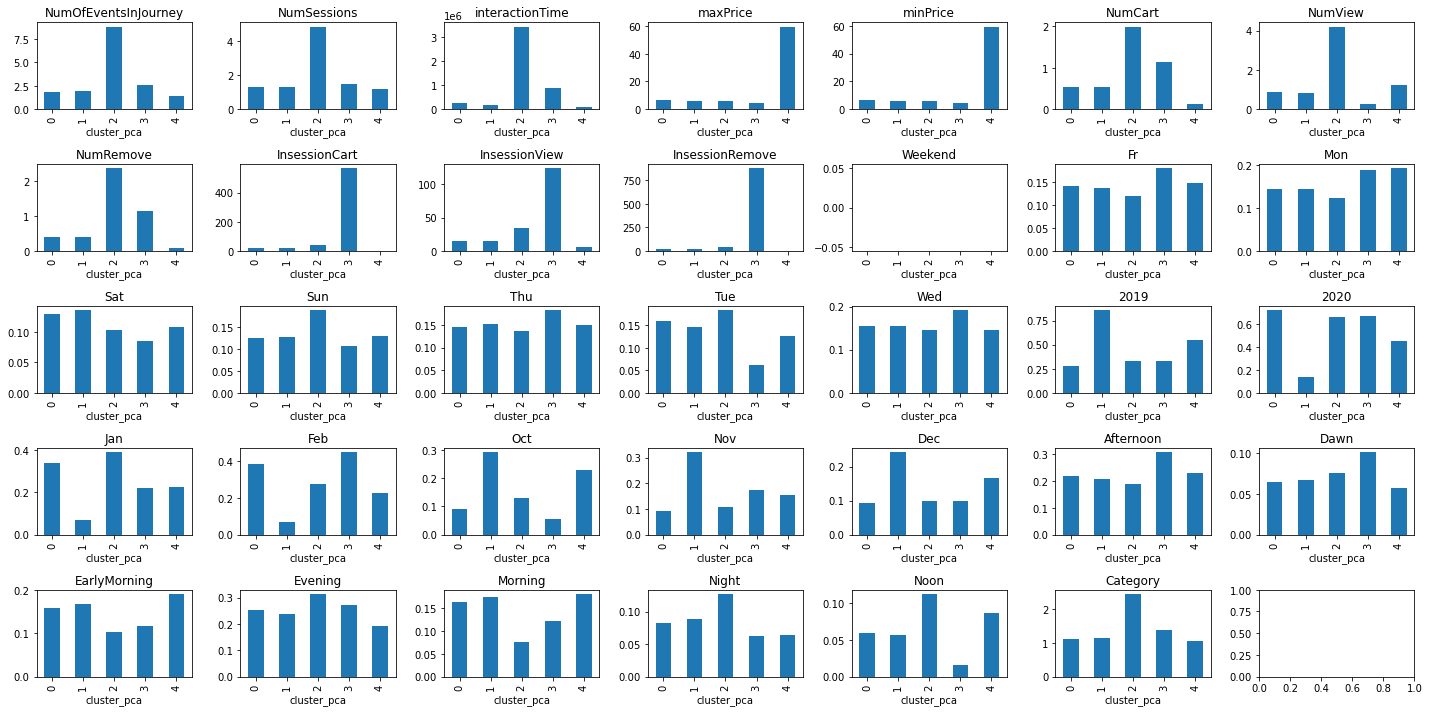

In [35]:
visualize_features_by_cluster(past, 'cluster_pca', X.columns)

*In this graphic we can visualize features for each of the clusters and see which features are emphasized within each component.*

In [36]:
past.groupby('cluster_pca').mean() # Group by the cluster labels and calculate the mean

,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
cluster_pca,,,,,,,,,,,,,,,,,,,,,
0,5.603451e+06,5.327650e+08,1.873149,1.291304,2.401754e+05,6.283795,6.254350,0.524110,0.859979,0.388583,...,0.094109,0.218560,0.064186,0.158763,0.251825,0.164703,0.082417,0.342209,0.059545,1.125972
1,5.544681e+06,5.152000e+08,1.895940,1.290674,1.882900e+05,5.605781,5.584227,0.542863,0.844058,0.403705,...,0.242893,0.206684,0.067245,0.166608,0.237890,0.175307,0.089172,0.350162,0.057093,1.133537
2,5.722259e+06,5.009907e+08,8.808805,4.876730,3.435609e+06,5.808129,5.565388,1.994789,4.202111,2.365094,...,0.097664,0.188320,0.076101,0.103639,0.314376,0.077134,0.127358,0.113208,0.113073,2.462040
3,5.852477e+06,4.944391e+08,2.560811,1.468468,8.855619e+05,4.729414,4.304459,1.132883,0.274775,1.144144,...,0.099099,0.308559,0.101351,0.117117,0.272523,0.121622,0.063063,0.054054,0.015766,1.396396
4,5.473270e+06,5.356414e+08,1.454898,1.177448,9.661491e+04,59.644009,59.595180,0.120686,1.226975,0.073140,...,0.166459,0.228595,0.057122,0.190954,0.191385,0.182171,0.063338,0.419580,0.086435,1.050668


In [37]:
past.groupby('cluster_pca')['Purchased?'].mean() # Inspect Purchased? by cluster

cluster_pca
0    0.342209
1    0.350162
2    0.113208
3    0.054054
4    0.419580
Name: Purchased?, dtype: float64

In [38]:
new_df = past.groupby('cluster_pca')['maxPrice', 'NumOfEventsInJourney', 'Purchased?'].mean()
new_df

/var/folders/02/t1w3xsh916z60p5jhmd5xbc00000gn/T/ipykernel_35848/1045476344.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  new_df = past.groupby('cluster_pca')['maxPrice', 'NumOfEventsInJourney', 'Purchased?'].mean()


,maxPrice,NumOfEventsInJourney,Purchased?
cluster_pca,,,
0,6.283795,1.873149,0.342209
1,5.605781,1.895940,0.350162
2,5.808129,8.808805,0.113208
3,4.729414,2.560811,0.054054
4,59.644009,1.454898,0.419580


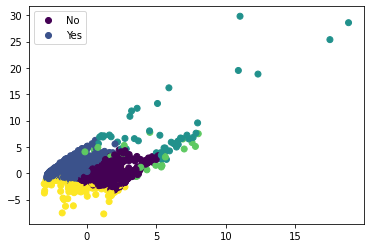

In [39]:
# visualize the clusters
visualize_2pcs(X_reduced, past['cluster_pca'])

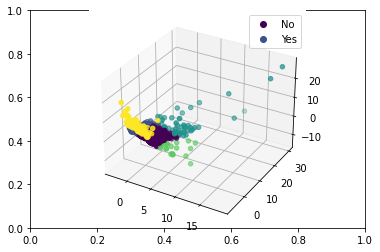

In [40]:
visualize_3pcs(X_reduced, past['cluster_pca'])

10. What are the assumptions for k-means? Judging by the cluster sizes, is k-means a good approach? 

In K-means the points within a cluster are more similar to each other than they are to other points in other clusters. The clustering sizes are so imbalanced that I don't think K-means is the best approach for this data. 

Scanning the list of [clustering algorithms](https://scikit-learn.org/stable/modules/clustering.html) implemented in scikit-learn, try at least one other algorithm, examine its assumptions, and intepret results.

    *YOUR ANSWER HERE*

In [50]:
# Use dbscan to cluster the data
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.3).fit(X_reduced) # Instantiate the DBSCAN object
labels = db.labels_ # Get the cluster labels
labels_true = y # Get the true labels

In [51]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # Calculate the number of clusters
n_noise_ = list(labels).count(-1) # Calculate the number of noise points

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 51
Estimated number of noise points: 4309


In [52]:
print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Homogeneity: 0.098
Completeness: 0.075
V-measure: 0.085
Adjusted Rand Index: -0.008
Adjusted Mutual Information: 0.078
Silhouette Coefficient: -0.778


    Running DBSCAN appears to output a poor performoing model and does not look like a good approach for the type of data we're working with. However, it's interesting that running the NCluster code reveals more than 50 clusters compared to our initial clusters of five. Next steps would include trying some other clustering algorithms and spending time on parameter tuning to see if I can improve the performance.

## Task 3. To launch or not to launch?

In this task, we will work on a hypothetical application: cosmetics purchase prediction for new products with limited features. The intention here is to maximize **recall** so that no popular cosmetic is understocked. Overstocking is less of a concern since it will not cause disengagement in customers.

The purchase status for each "new" product is known, but we only use the labels for benchmarking purpose. Instead, we use label spreading method to leverage a small amount of labeled data in combination with a larger amount of unlabeled data. 

1. Read in the data in `new.csv.gz` and save it as a `pd.DataFrame` named `new`. This is the test dataset.

    Look at the shape of `new` and inspect the frist few rows.

In [56]:
new = pd.read_csv('../dat/new.csv.gz') # this is the test data

In [57]:
assert new.shape == (30091, 5)

In [58]:
new.head()

,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


2. How does the number of data points in the training set (`past`) compare to the number of datapoints in the test set (`new`)? 

    And how does the feature set in the training set compare to the feature set in the test set?

        The training set is relatively smaller than the test set. However, the training set has 6x more features.

3. Are there any product ids in both the training and test datasets? Hint: use `np.intersect1d` or set operations.

In [59]:
len(set(new['product_id']).intersection(set(past['product_id'])))

0

4. What percentage of data points resulted in a purchase in the test set?

    In reality, we won't be able to calculate information that is not available to you. Here, we simply demonstrated that the distributions in target between `past` and `new` are similar. 

In [60]:
test_purchased = new['Purchased?'].mean()
training_purchased = past['Purchased?'].mean()
print(f"The percentage of test data that resulted in a purchase is {round(test_purchased,4)} percent.")
print(f"The percentage of training data that resulted in a purchase is {round(training_purchased,4)} percent.")

The percentage of test data that resulted in a purchase is 0.3443 percent.
The percentage of training data that resulted in a purchase is 0.3438 percent.


5. Create `ndarray`s: `X_train`, `y_train`, `X_test`, and `y_test` according to the following guidelines.

    - The `Purchased?` column is the target.
    - `X_train` and `X_test` should contain the same features
    - `product_id` should not be a feature.

    Double check that the shapes of the four arrays are what you expect.

In [61]:
X = new.drop(labels=['product_id'], axis=1) # Drop the product_id column
y = X.pop('Purchased?') # Get the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # Split the data
X_train = X_train.to_numpy() # Convert the data to numpy arrays
y_train = y_train.to_numpy() #

In [62]:
assert X_train.shape[0] == y_train.shape[0] # 5000
assert X_train.shape[1] == X_test.shape[1]  # 3

assert type(X_train) == np.ndarray # make sure you import numpy as np at this point
assert type(X_train).__module__ == type(y_train).__module__ == np.__name__  # alternative way

6. Let's fit a simple logistic regression on the training set (`X_train`, `y_train`) and report performance on the test set (`X_test`, `y_test`).

In [63]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      3961
           1       0.82      0.49      0.61      2058

    accuracy                           0.79      6019
   macro avg       0.80      0.72      0.73      6019
weighted avg       0.79      0.79      0.77      6019



/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


7. Re-assemble data for semi-supervised learning. 
    - Use the features from the test set along with the features from the training set. 
    - Only use the labels from the training set but none from the test set.  
    
    Since we're using a large number of sampled features, but only a small number of these samples have labels, this is **semi-supervised learning**.

Create a matrix `X` that has the rows from `X_train` concatenated with the rows from `X_test`. Check the shape of the matrix.

In [64]:
new.shape

(30091, 5)

In [65]:
past.shape

(5000, 38)

In [66]:
# Combine rows of X_train and X_test
X = np.concatenate((X_train, X_test), axis=0)

In [67]:
X.shape

(30091, 3)

In [68]:
assert X.shape == (30091, 3)

Create the target array `y` by concatenating `y_train` with a vector of -1's, effectively creating a dummy label for the `X_test` rows in `X`. Check the shape of the array. It should have as many values as `X` has rows.

In [69]:
y = np.concatenate((y_train, np.full(X_test.shape[0], -1)), axis=0)

In [70]:
assert X.shape[0] == y.shape[0]

8. Semi-supervised learning. 

    Scikit-learn provides two label propagation models: [`LabelPropagation`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelPropagation.html) and [`LabelSpreading`](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html). Both work by constructing a similarity graph over all items in the input dataset. `LabelSpreading` is similar to the basic Label Propagation algorithm, but it uses an affinity matrix based on the normalized graph Laplacian and soft clamping across the labels; thus more robust to noise. We will be using scikit-learn's `LabelSpreading` model with `kNN`.
    
    Train a `LabelSpreading` model. Set `kernel` to `knn` and `alpha` to 0.01.

In [71]:
# Train a LabelSpreading model. Set kernel to KNN and alpha to 0.01
from sklearn.semi_supervised import LabelSpreading
label_model = LabelSpreading(kernel='knn', alpha=0.01)
label_model.fit(X, y)

LabelSpreading(alpha=0.01, kernel='knn')

9. Extract the predictions for the test data. 

    You can get the predictions from the `transduction_` attribute. Note that there is a value for every row in `X`, so select just the values that correspond to `X_test`.

In [72]:
#Extract the predictions for the test data
semi_sup_preds = label_model.transduction_[X_train.shape[0]:] 

In [73]:
assert semi_sup_preds.shape[0] == X_test.shape[0]

10. Print the classification report

In [74]:
print(classification_report(y_test, semi_sup_preds)) # Print the classification report

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3961
           1       0.84      0.72      0.77      2058

    accuracy                           0.86      6019
   macro avg       0.85      0.82      0.83      6019
weighted avg       0.85      0.86      0.85      6019



Let's bring the performance from the supervised learning model down to see the comparison; discuss the areas of improvement and reasons for improvement.

In [75]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      0.94      0.85      3961
           1       0.82      0.49      0.61      2058

    accuracy                           0.79      6019
   macro avg       0.80      0.72      0.73      6019
weighted avg       0.79      0.79      0.77      6019



/opt/homebrew/Caskroom/miniforge/base/envs/fastai/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


    It appears the semi-supervised model performed better than the supervised model. The semi-supervised model has a higher F1 score (~.04) for the first class (0), and an even bigger F1 bump for the second class (1) of 77% compared to 61% in the supervised learning model. It looks like the labeling conducted via the semi-supervised methodolgy helped to improve the performance and accuracy of the model. 

11. Read [Small Data Can Play a Big Role in AI](https://hbr.org/2020/02/small-data-can-play-a-big-role-in-ai) and discuss with your teammate about AI tools for training AI with small data and their use cases. 

## Acknowledgement & References

- data was adapted from Kaggle: [eCommerce Events History in Cosmetics Shop](https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop)
- function `visualize_silhouette` was adapted from [plot_kmeans_silhouette_analysis by scikit-learn](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Categorizing Online Shopping Behavior from Cosmetics to Electronics: An Analytical Framework](https://arxiv.org/pdf/2010.02503.pdf)
- [OPAM: Online Purchasing-behavior Analysis using Machine learning](https://arxiv.org/pdf/2102.01625.pdf)